In [69]:
from multiprocessing import Pool

from functools import partial
import matplotlib.pyplot as plt
import msprime
import numpy as np

from bgspy.theory import bgs_segment

In [24]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False 

## B Loss Limit

In [55]:
a = np.load('../bmap_hg38_reps.npz')

In [58]:
a['y'], a['targets']

(array([[3.09132861e+03, 7.72832153e-01, 1.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [6.17066694e+03, 1.54266673e+00, 9.99605550e-01, 3.71233840e-08,
         0.00000000e+00],
        [3.99188801e+03, 9.97972003e-01, 9.99996240e-01, 1.07421587e-09,
         0.00000000e+00],
        ...,
        [6.28491339e+03, 1.57122835e+00, 1.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [3.86361183e+03, 9.65902959e-01, 1.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [5.14916125e+03, 1.28729031e+00, 1.00000000e+00, 0.00000000e+00,
         0.00000000e+00]]),
 array(['pi', 'Bhat', 'Ef', 'Vf', 'load'], dtype='<U4'))

[]

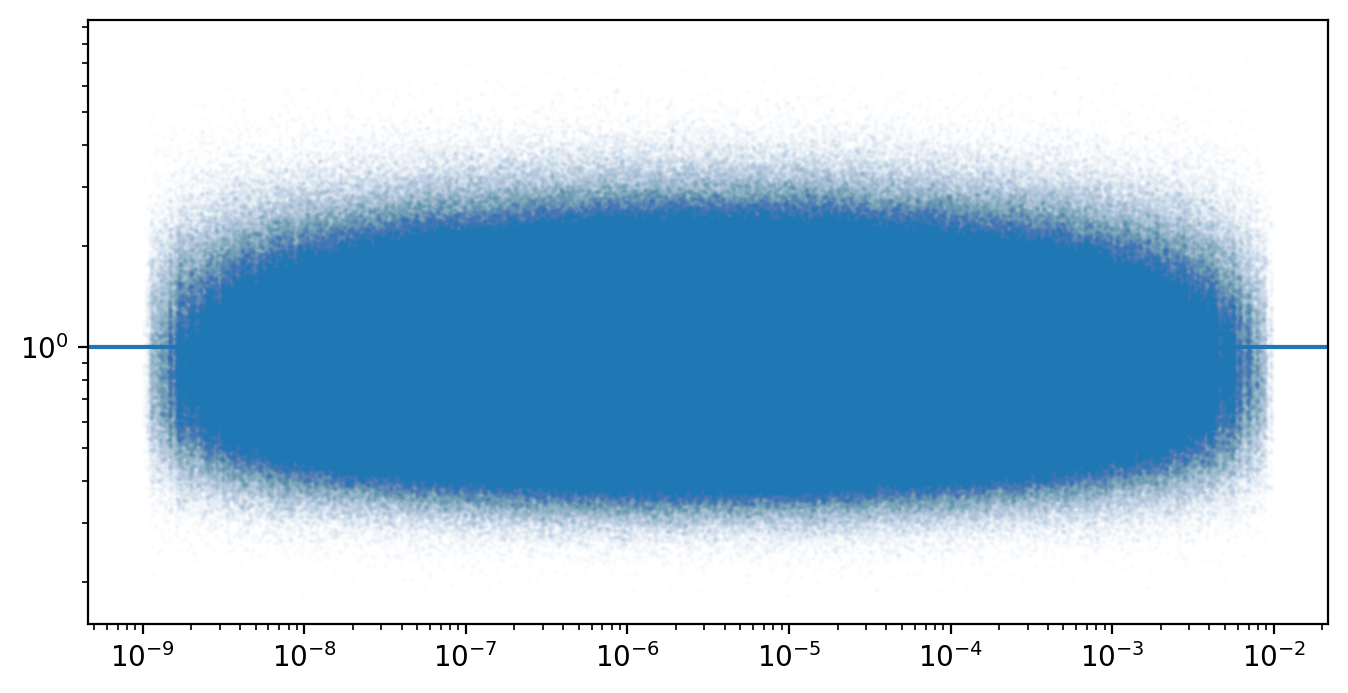

In [147]:
plt.scatter(a['X'][:, 0] / a['X'][:, 1], a['y'][:, 1], alpha=0.01, s=1)
plt.axhline(1)

In [25]:
Bs = np.random.uniform(0, 1, 1000)

In [28]:
def bgs_runner(B, N=1000, nreps=1, mc_nreps=10):
    Bhats = np.array([np.mean([msprime.sim_ancestry(N, population_size=B*N).diversity(mode='branch')/(4*N) for _ in range(nreps)]) for _ in range(mc_nreps)])
    # MSE = var if bias is 0
    return np.mean((Bhats - B)**2)

res = dict()
nrs = [1, 5, 10, 50, 100]
for nr in nrs:
    print(nr)
    with Pool(70) as p:
        res[nr] = np.array(p.map(partial(bgs_runner, nreps=nr), Bs))

1
5
10
50
100


In [18]:
def B_var(B):
    #return (n+1) * B / (12*N*mu*(n-1)) + (2*(n**2 + n +3) *B**2)/(9*n*(n-1))
    return 2/9 * B**2


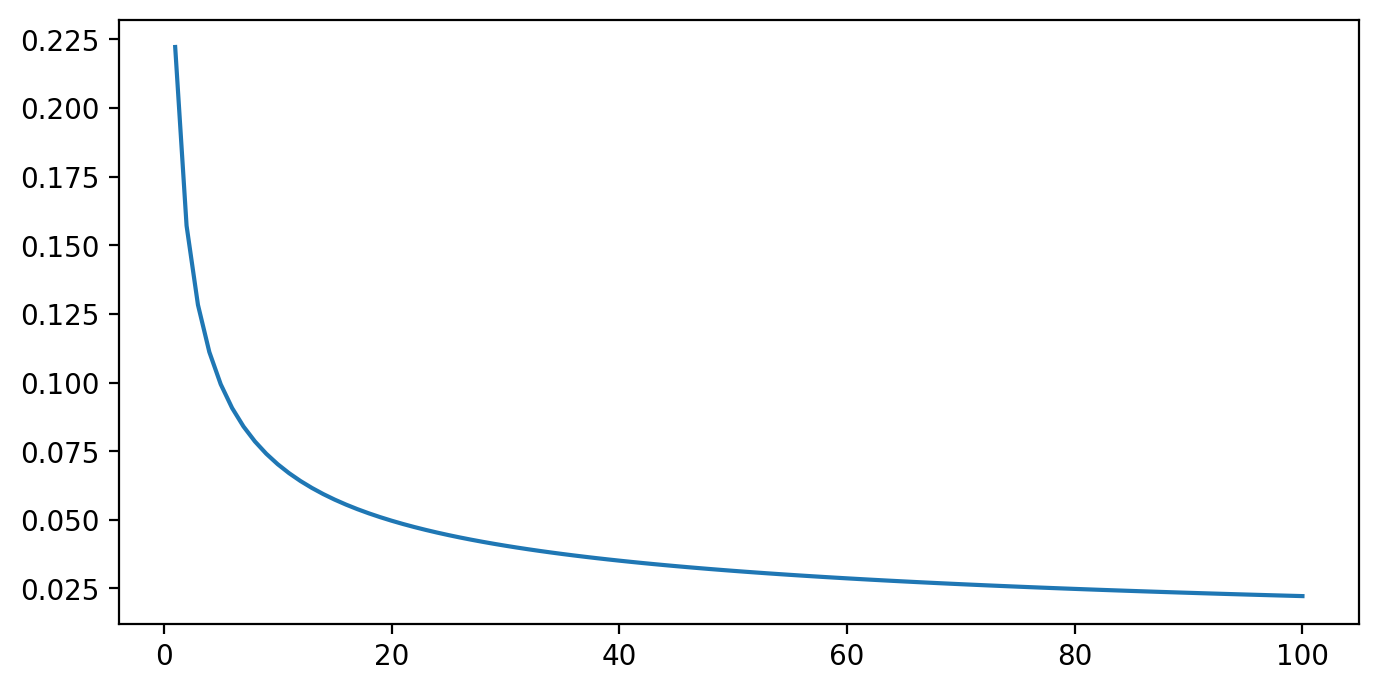

In [19]:
z = np.linspace(1, 100, 100)
plt.plot(z, B_var(1) / np.sqrt(z))

In [29]:
nrs = [1, 5, 10, 50, 100]

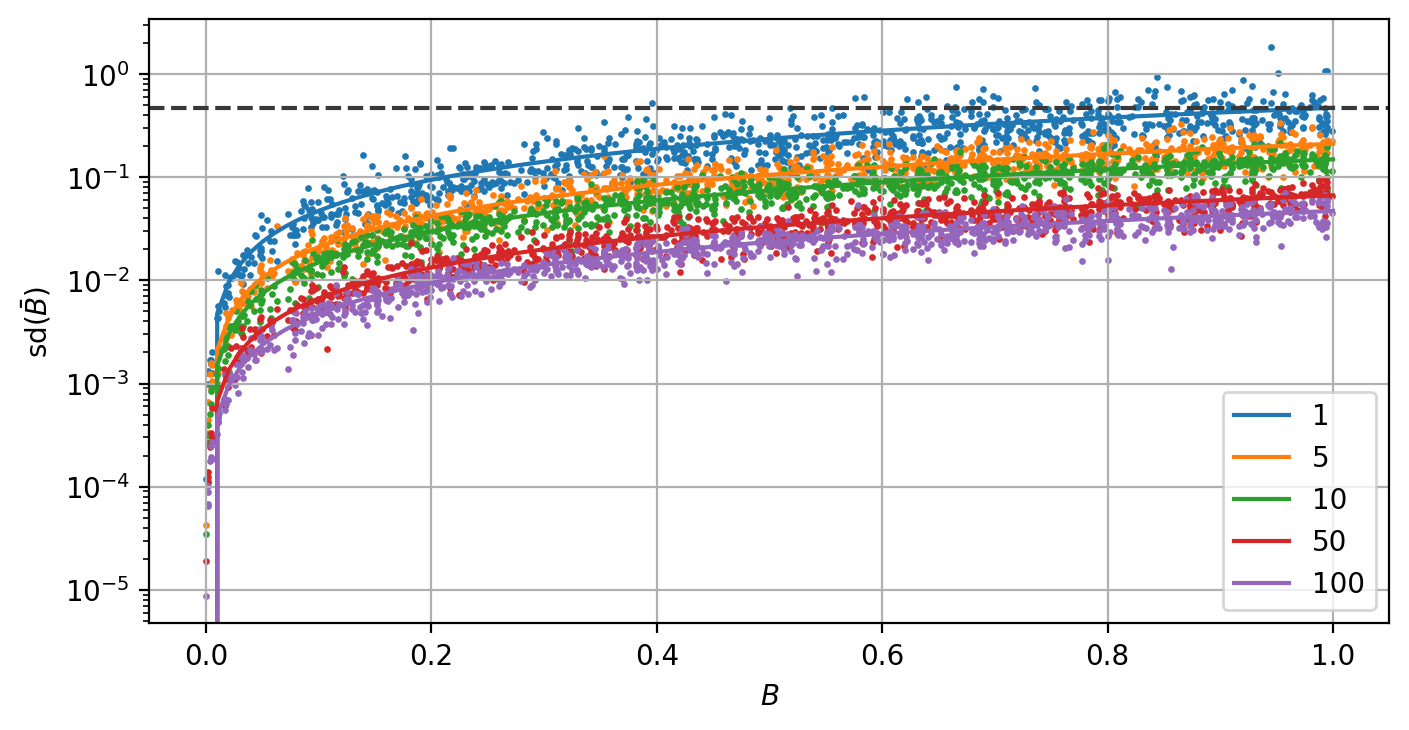

In [53]:
fig, ax = plt.subplots()
b = np.linspace(0, 1, 100)

for nr in nrs:
    pts = ax.scatter(Bs, np.sqrt(res[nr]), s=2)
    ax.plot(b, np.sqrt(B_var(b)/nr), c=pts.get_facecolors(), label=nr)
ax.axhline(np.sqrt(2/9), linestyle='dashed', c='0.22')
ax.semilogy()
#ax.loglog()
ax.set_ylabel("$\\mathrm{sd}(\\bar{B})$") 
ax.set_xlabel("$B$")
ax.legend()
ax.grid()

Text(0.5, 0, 's')

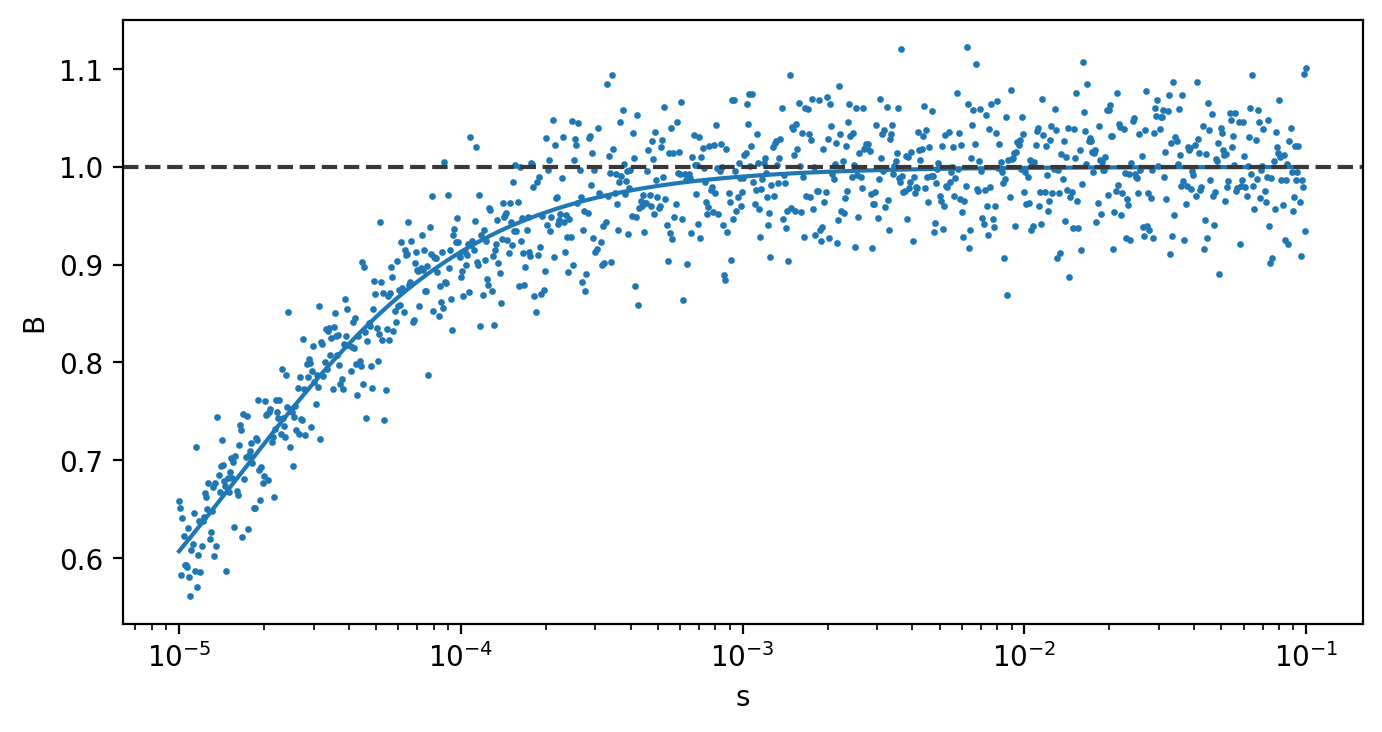

In [140]:
s = np.logspace(-5, -1, 1000)
B = bgs_segment(1e-8, s, 1000, 1e-8, 1e-8)
plt.plot(s, B)
R = 100
plt.scatter(s, B + np.random.normal(0, np.sqrt(B_var(B)/R), len(B)), s=2)
plt.semilogx()
plt.axhline(1, c='0.22', linestyle='dashed')
plt.ylabel('B')
plt.xlabel('s')

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


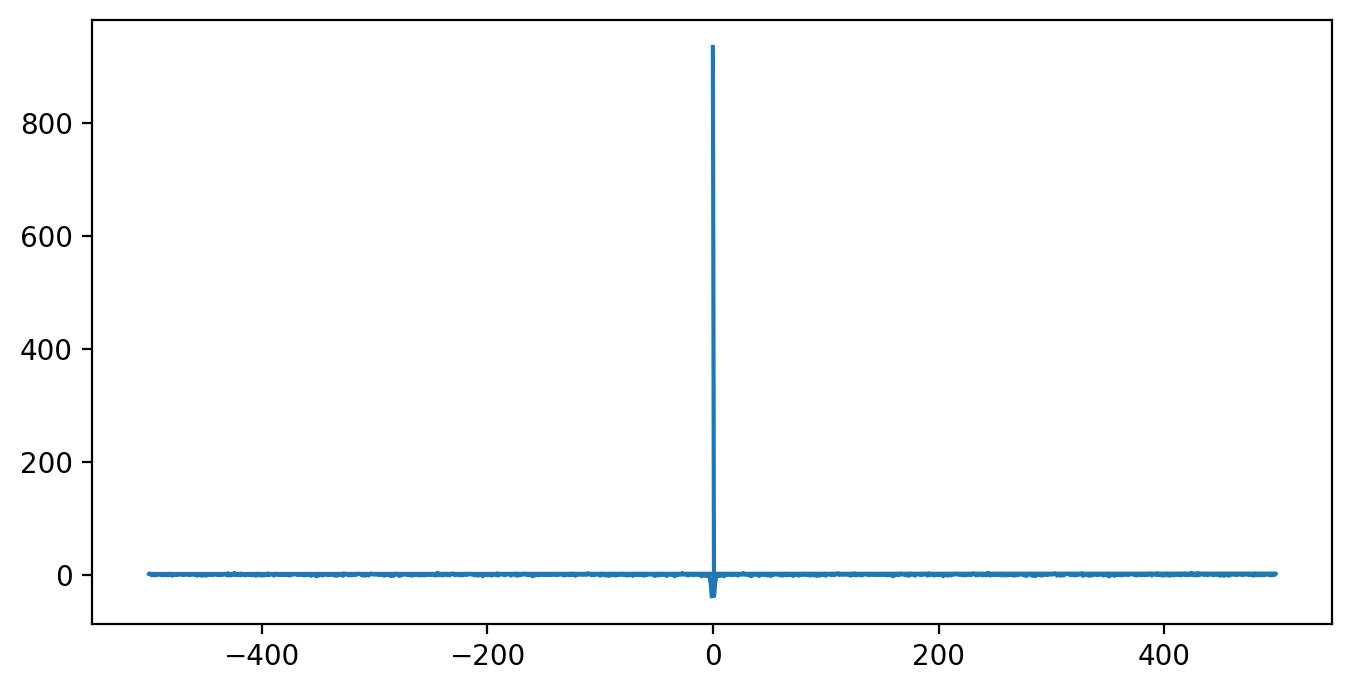

In [130]:
b = B + np.random.normal(0, np.sqrt(B_var(B)/R), len(B))
from scipy.fft import fft, fftfreq

plt.plot(fftfreq(len(b), 0.001), fft(b))


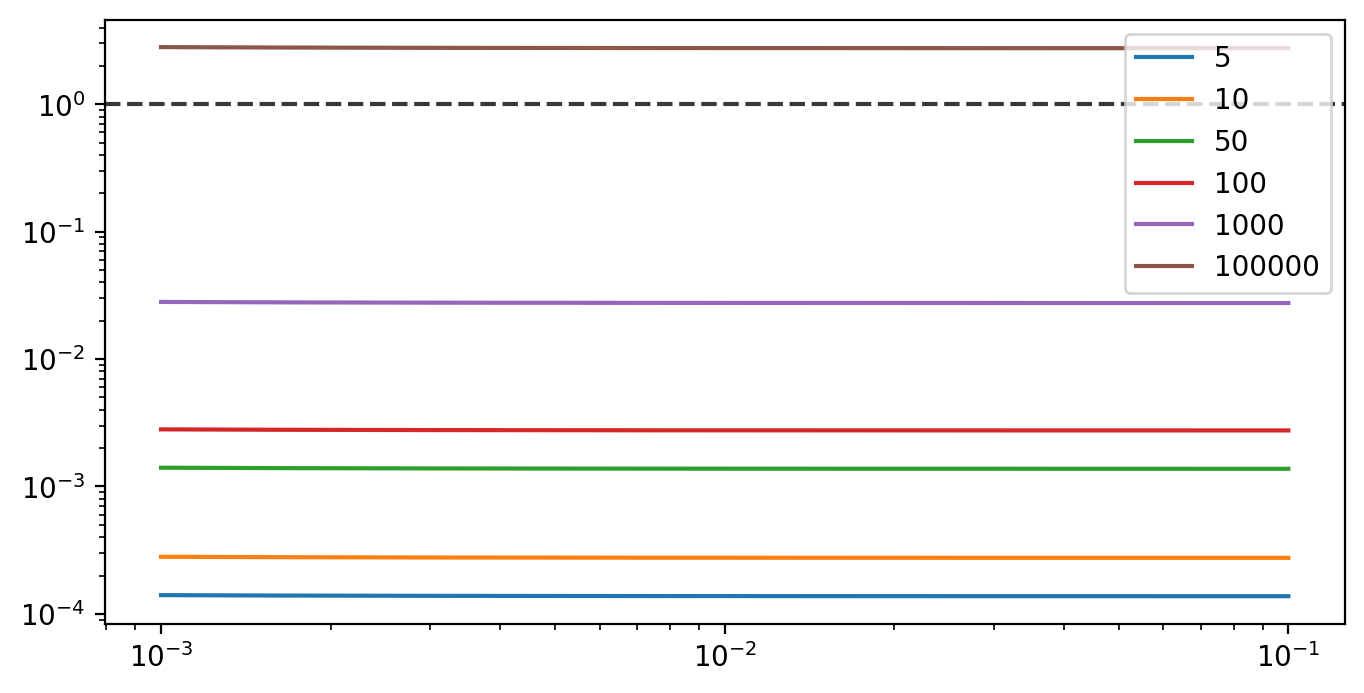

In [159]:
s = np.logspace(-3, -1, 1000)
B = bgs_segment(1e-8, s, 1000, 1e-8, 1e-8)

for r in [5, 10, 50, 100, 1000, 100_000]:
    S = np.var(B)
    N = B_var(B)/r
    plt.plot(s, S/N, label=r)
plt.axhline(1, c='0.22', linestyle='dashed')
#plt.scatter(s, B + np.random.normal(0, np.sqrt(B_var(B)/R), len(B)), s=2)
plt.loglog()
plt.legend()

## Multiplicative Error of B

There are two possible error models:

1. Product error model, e.g. $B = \prod_i^n (B_i + \varepsilon_i)$
2. Rate error model, e.g. $B = \prod_i^n \exp(\lambda_i + \varepsilon_i)$

It's not clear which is appropriate — either way, we want to quantify $\mathrm{Var}(B)$.

### Product Error Model

$$ B = \prod_i^n (B_i + \varepsilon_i) $$
$$ \log(B) = \sum_i^n \log(B_i + \varepsilon_i) $$

Taylor expansion around $\varepsilon_i = 0$:

$$ \log(B) \approx \sum_i^n \log(B_i) + \sum_i^n \frac{\varepsilon_i}{B_i} $$

If $\varepsilon_i \sim N(0, \sigma^2)$, then each term of the sum can be written as a rescaled normal, e.g. $e_i \sim N(0, \sqrt{B_i} \sigma^2)$

$$ \log(B) \approx \sum_i^n \log(B_i) + \sum_i^n e_i $$


$$ B \approx \prod_i^n B_i \exp\left(\sum_i^n e_i\right) $$

$$ \mathrm{Var}(B) \approx \prod_i^n B_i \mathrm{Var}(X) $$

where $X = \exp\left(\sum_i^n e_i\right)$ is log-normally distributed with variance $c^2 = \sum_i^n\sqrt{B_i} \sigma^2$ (since the sum of log-normals is log-normal with summed mean and variance). Thus, 

$$ \mathrm{Var}(B) \approx \left(\prod_i^n B_i \right) (\exp(c^2)-1)\exp(2 \mu + c^2) $$

### Rate Error Model

The math of this model is much simpler since error only affects the rate.

$$B = \prod_i^n \exp(\lambda_i + \varepsilon_i)$$

$$\log(B) = \sum_i^n \lambda_i + \sum_i^n \varepsilon_i$$

We can see that this is now like the past problem, 

$$ \mathrm{Var}(B) \approx \prod_i^n B_i \mathrm{Var}(X) $$
 
where $X$ is also log-normal. Assuming i.i.d. $\varepsilon_i$ terms, $c^2 = n \sigma^2$



In [1]:
def product_error_model(b, sd, bias=0):
    B = np.prod(b)
    return np.mean([(np.prod(b + np.random.normal(bias, sd, len(b)))-B)**2 for _ in range(10)])

def rate_error_model(b, sd, bias=0):
    B = np.prod(b)
    rate = np.log(b)
    return np.mean([(np.prod(np.exp(rate + np.random.normal(bias, sd, len(b))))-B)**2 for _ in range(10)])

In [2]:
def product_var(b, sd, bias=0):
    c2 = np.sum(np.sqrt(b)) * sd**2
    return np.prod(b)**2*np.exp(c2 + 2*bias)*(np.exp(c2) - 1)

def rate_var(b, sd, bias=0):
    n = len(b)
    c2 = n * sd**2
    return np.prod(b)**2*np.exp(c2 + 2*bias)*(np.exp(c2) - 1)

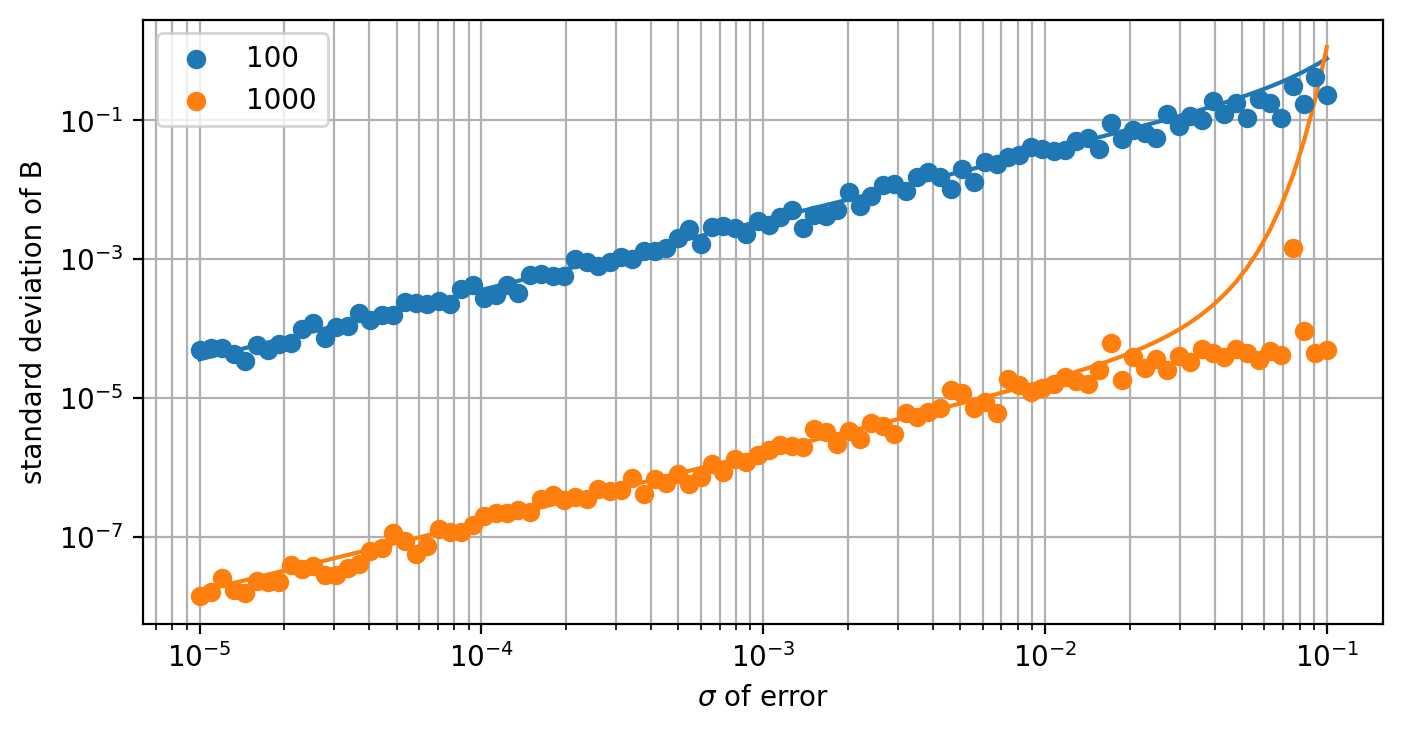

In [7]:
fig, ax = plt.subplots()

nsites = 100
b = np.random.beta(100, 1, nsites)

sd = 10**np.linspace(-5, -1, 100)
ax.scatter(sd, np.sqrt([np.mean(product_error_model(b, s)) for s in sd]), zorder=3, label=nsites)
#ax.scatter(sd, np.sqrt([np.mean(rate_error_model(b, s)) for s in sd]), zorder=3)
#ax.plot(sd, np.sqrt([product_var(b, s) for s in sd]))
ax.plot(sd, np.sqrt([rate_var(b, s) for s in sd]))

nsites = 1000
b = np.random.beta(100, 1, nsites)


sd = 10**np.linspace(-5, -1, 100)
ax.scatter(sd, np.sqrt([np.mean(product_error_model(b, s)) for s in sd]), zorder=3, label=nsites)
#ax.scatter(sd, np.sqrt([np.mean(rate_error_model(b, s)) for s in sd]), zorder=3)
#ax.plot(sd, np.sqrt([product_var(b, s) for s in sd]))
ax.plot(sd, np.sqrt([rate_var(b, s) for s in sd]))
ax.grid(which='both')
ax.set_ylabel("standard deviation of B")
ax.set_xlabel("$\sigma$ of error")
ax.loglog()
ax.legend()

ax.axvline()

In [11]:
b.shape

(1000,)

In [28]:
np.abs(np.prod(b) - np.prod(b + np.random.normal(0, 1e-5, 1000))), np.prod(b), np.var(b)

(3.505235175406467e-08, 5.1424165962731995e-05, 9.697862473408391e-05)

In [220]:
np.tile([1, 2, 10], 10)

array([ 1,  2, 10,  1,  2, 10,  1,  2, 10,  1,  2, 10,  1,  2, 10,  1,  2,
       10,  1,  2, 10,  1,  2, 10,  1,  2, 10,  1,  2, 10])

In [222]:
np.repeat([1, 2, 3], 10)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])